In [1]:
# Data handling
import pandas as pd  # For reading CSV and manipulating dataframes
import numpy as np   # For numerical operations

# Visualization
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns            # For advanced plots like heatmaps

# Machine Learning
from sklearn.model_selection import train_test_split  # Split dataset into train/test
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # Scale numeric, encode categorical
from sklearn.impute import SimpleImputer  # Handle missing values
from sklearn.compose import ColumnTransformer  # Apply different preprocessing to numeric/categorical features
from sklearn.pipeline import Pipeline  # Chain preprocessing and model
from sklearn.linear_model import LinearRegression  # Baseline model
from sklearn.ensemble import RandomForestRegressor  # Better model

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error  # MAE/RMSE metrics

# Saving
import joblib  # Save/load trained model
import json    # Save metrics in JSON format


In [2]:
# Load dataset
data = pd.read_csv("/kaggle/input/house-price-prediction-dataset/House Price Prediction Dataset.csv")

# Drop Id column (useless for prediction)
X = data.drop(columns=['Id', 'Price'])
y = data['Price']

# Split dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Area         0
Bedrooms     0
Bathrooms    0
Floors       0
YearBuilt    0
Location     0
Condition    0
Garage       0
dtype: int64


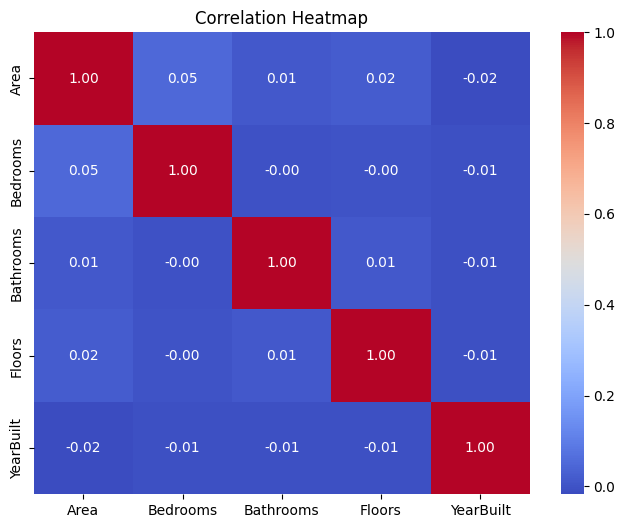

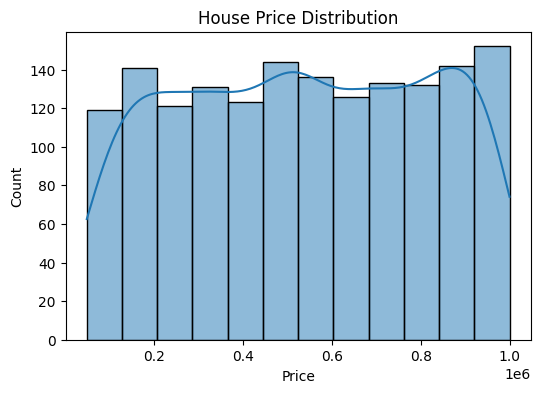

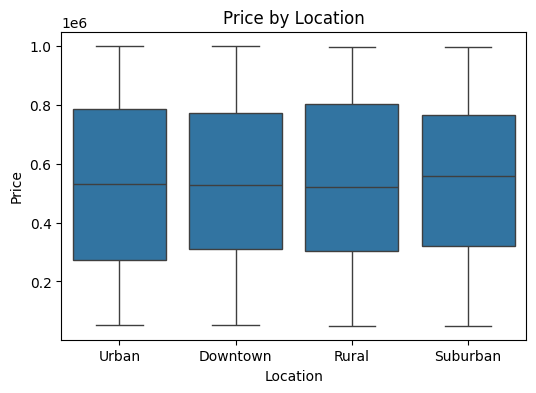

In [3]:
# Check missing values
print(X.isnull().sum())

# Separate numeric and categorical features
numerical_features = ['Area','Bedrooms','Bathrooms','Floors','YearBuilt']
categorical_features = ['Location','Condition','Garage']

# Correlation heatmap for numeric features
plt.figure(figsize=(8,6))
sns.heatmap(X_train[numerical_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Price distribution
plt.figure(figsize=(6,4))
sns.histplot(y_train, kde=True)
plt.title("House Price Distribution")
plt.show()

# Boxplot: Price vs Location
plt.figure(figsize=(6,4))
sns.boxplot(x='Location', y=y_train, data=X_train.join(y_train))
plt.title("Price by Location")
plt.show()


In [4]:
# Numeric preprocessing: fill missing with median + scale features
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical preprocessing: fill missing with most frequent + one-hot encode
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing for numeric and categorical features
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])


In [5]:
# Linear Regression pipeline
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train linear regression
lr_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred_lr = lr_pipeline.predict(X_test)

# Evaluate performance
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = mean_squared_error(y_test, y_pred_lr)

print(f"Linear Regression Performance: MAE={mae_lr:.2f}, RMSE={rmse_lr:.2f}")


Linear Regression Performance: MAE=243241.98, RMSE=78321466146.03


In [6]:
# Random Forest pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train
rf_pipeline.fit(X_train, y_train)


# Predict
y_train_pred = rf_pipeline.predict(X_train)
y_test_pred = rf_pipeline.predict(X_test)

# Evaluate performance
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = mean_squared_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = mean_squared_error(y_test, y_test_pred)

print(f"Random Forest Performance:")
print(f"Train MAE: {train_mae:.2f}, Train RMSE: {train_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}, Test RMSE: {test_rmse:.2f}")


Random Forest Performance:
Train MAE: 91107.96, Train RMSE: 11579378028.79
Test MAE: 254587.84, Test RMSE: 86571527999.46


In [7]:
# Save metrics
metrics = {
    "LinearRegression": {"MAE": mae_lr, "RMSE": rmse_lr},
    "RandomForest": {"Train MAE": train_mae, "Train RMSE": train_rmse,
                     "Test MAE": test_mae, "Test RMSE": test_rmse}
}

with open("metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

# Save trained Random Forest pipeline
joblib.dump(rf_pipeline, "house_price_model.pkl")


['house_price_model.pkl']

In [8]:
import pandas as pd
import joblib

# Load trained model
model = joblib.load("house_price_model.pkl")

print("🏠 House Price Prediction CLI")
print("Please enter house details as prompted.\n")

# Get inputs from user with clear instructions
while True:
    try:
        area = int(input("Enter Area in square feet (e.g., 2500): "))
        break
    except ValueError:
        print("⚠️ Please enter an integer number for Area.")

while True:
    try:
        bedrooms = int(input("Enter Number of Bedrooms (e.g., 3): "))
        break
    except ValueError:
        print("⚠️ Please enter an integer number for Bedrooms.")

while True:
    try:
        bathrooms = int(input("Enter Number of Bathrooms (e.g., 2): "))
        break
    except ValueError:
        print("⚠️ Please enter an integer number for Bathrooms.")

while True:
    try:
        floors = int(input("Enter Number of Floors (e.g., 2): "))
        break
    except ValueError:
        print("⚠️ Please enter an integer number for Floors.")

while True:
    try:
        year_built = int(input("Enter Year Built (e.g., 2015): "))
        break
    except ValueError:
        print("⚠️ Please enter a valid year (integer).")

# Categorical inputs
location = input("Enter Location (Urban, Suburban, Downtown, Rural): ").capitalize()
condition = input("Enter Condition (Excellent, Good, Fair, Poor): ").capitalize()
garage = input("Enter Garage (Yes/No): ").capitalize()

# Create DataFrame for prediction
new_house = pd.DataFrame({
    "Area": [area],
    "Bedrooms": [bedrooms],
    "Bathrooms": [bathrooms],
    "Floors": [floors],
    "YearBuilt": [year_built],
    "Location": [location],
    "Condition": [condition],
    "Garage": [garage]
})

# Predict price
predicted_price = model.predict(new_house)[0]

# Confidence range ±10%
lower_bound = predicted_price * 0.9
upper_bound = predicted_price * 1.1

# Display result nicely
print("\n✅ Prediction Complete!")
print(f"Predicted House Price: ${predicted_price:,.0f}")
print(f"Estimated Price Range: ${lower_bound:,.0f} - ${upper_bound:,.0f}")


🏠 House Price Prediction CLI
Please enter house details as prompted.



Enter Area in square feet (e.g., 2500):  3000
Enter Number of Bedrooms (e.g., 3):  4
Enter Number of Bathrooms (e.g., 2):  3
Enter Number of Floors (e.g., 2):  3
Enter Year Built (e.g., 2015):  2022
Enter Location (Urban, Suburban, Downtown, Rural):  urban
Enter Condition (Excellent, Good, Fair, Poor):  good
Enter Garage (Yes/No):  yes



✅ Prediction Complete!
Predicted House Price: $455,693
Estimated Price Range: $410,123 - $501,262
